In [2]:
from tensorflow.keras.applications import VGG16, DenseNet121
import pathlib
import cv2
import os
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import json
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Config

It was a file but in order to not load every time I created a class

In [4]:
class Config:
  def __init__(self):
    self.ANIMALS = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant',
                    'horse', 'sheep', 'spider',
                    'squirrel', 'zebra', 'rhino', 'buffalo']
    self.IMAGE_SHAPE = (224, 224)

    self.ANIMAL_LABEL_DICT = {
        'butterfly': 0,
        'cat': 1,
        'chicken': 2,
        'cow': 3,
        'dog': 4,
        'elephant': 5,
        'horse': 6,
        'sheep': 7,
        'spider': 8,
        'squirrel': 9,
        'zebra': 10,
        'rhino': 11,
        'buffalo': 12}

    self.REVERSE_ANIMAL_DICT = {0: 'butterfly',
                          1: 'cat',
                          2: 'chicken',
                          3: 'cow',
                          4: 'dog',
                          5: 'elephant',
                          6: 'horse',
                          7: 'sheep',
                          8: 'spider',
                          9: 'squirrel',
                          10: 'zebra',
                          11: 'rhino',
                          12: 'buffalo'}

    self.DATA_PATH = os.getcwd() + '/drive/MyDrive/data/'
    self.PROCESSED_IMAGE_PATH = os.getcwd() + '/drive/MyDrive/ProcessedImages/'
    self.BEST_MODEL_FOLDER = '/drive/MyDrive/GridResults/BestModel/'
    self.BEST_MODEL = self.BEST_MODEL_FOLDER + 'best_model.keras'

config = Config()

## Check Available Images

In [5]:
pictures_per_cat = 1000

def read_files(folder, animal):
    animal_folder = pathlib.Path(folder + animal)

    animal_pictures = list(animal_folder.glob('*'))[:pictures_per_cat]

    return animal_pictures

animal_pictures = {}

for animal in config.ANIMALS:
    animal_pictures[animal] = read_files(config.DATA_PATH, animal)

for key, value in animal_pictures.items():
  print(f'There are {len(value)} in {key}')

There are 1000 in butterfly
There are 1000 in cat
There are 1000 in chicken
There are 1000 in cow
There are 1000 in dog
There are 1000 in elephant
There are 1000 in horse
There are 1000 in sheep
There are 1000 in spider
There are 1000 in squirrel
There are 1000 in zebra
There are 1000 in rhino
There are 1000 in buffalo


## Preprocess images for which the preprocessed version is not available on the drive.

In [6]:
def check_created_animal_arrays():
  processed_array_folder = pathlib.Path(config.PROCESSED_IMAGE_PATH)
  animal_collection = list(processed_array_folder.glob('*'))

  existing_animals = [animal.parts[-1].split('_')[0] for animal in animal_collection]

  return existing_animals

def create_animal_arrays():

  created_animal_arrays = check_created_animal_arrays()
  for animal_name, images in animal_pictures.items():
    if animal_name not in created_animal_arrays:
      print(animal_name)

      X = []
      counter = 0
      for image in images[:1000]:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)


        counter += 1
        if counter % 100 == 0:
          print(f'{animal_name} at {counter}')

      np.save(f'{config.PROCESSED_IMAGE_PATH}{animal_name}_1000_images.npy',
                    np.array(X).astype(np.float16))


create_animal_arrays()

## Load Preprocessed Data and Create X, y for the model

In [7]:
%%time
def read_and_merge_animal_arrays(start, end):
    # load_image_number = min((load_image_number, (start, end) = (0, 1000)))

    X_list = []  # List to store X arrays
    y_list = []  # List to store corresponding y values

    existing_animals = check_created_animal_arrays()
    for animal_name in existing_animals:

      # print(animal_name)
      # Load the X array for the current animal
      X_filepath = os.path.join(config.PROCESSED_IMAGE_PATH, f"{animal_name}_1000_images.npy")
      X = np.load(X_filepath)
      X = X[start:end]
      X_list.append(X)

      # Create corresponding y values for the animal
      y = np.full(X.shape[0], config.ANIMAL_LABEL_DICT[animal_name])  # Assuming animal_names is a list
      y_list.append(y)

    # Merge the X and y arrays
    merged_X = np.vstack(X_list)
    merged_y = np.concatenate(y_list)

    return merged_X, merged_y

# Load only N for each classes, cause of memory problem
X, y = read_and_merge_animal_arrays(0, 900)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_shape_before_aug = X_train.shape
del X, y


X_val, y_val = read_and_merge_animal_arrays(900, 1000)

CPU times: user 1.04 s, sys: 5.62 s, total: 6.65 s
Wall time: 53.8 s


## Data Augmentation

#### Define ImageDataGenerator

In [8]:
%%time
# Create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator to your original training data (optional but recommended)
datagen.fit(X_train)

# Create an iterator to generate augmented images and labels
augmented_data_iterator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)

CPU times: user 8.59 s, sys: 2.6 s, total: 11.2 s
Wall time: 11.1 s


#### Add Augmentations to the Original Dataset

In [9]:
# Create lists to store augmented data
augmented_X = []
augmented_y = []

# Iterate through batches of augmented data
for counter, batch in enumerate(augmented_data_iterator):

    X_batch, y_batch = batch

    # Append the augmented data to the lists
    augmented_X.append(X_batch)
    augmented_y.append(y_batch)

    if (counter+1) % 10 == 0:
      print(f'Iteration {counter+1} has finished')


    if counter == 40 - 1:
      break

# Concatenate augmented_X and augmented_y lists along axis 0
augmented_X = np.concatenate(augmented_X, axis=0)
augmented_y = np.concatenate(augmented_y, axis=0)

# Append the augmented data to your original dataset
X_train = np.concatenate((X_train, augmented_X.astype(np.float16)), axis=0)
y_train = np.concatenate((y_train, augmented_y), axis=0)

Iteration 10 has finished
Iteration 20 has finished
Iteration 30 has finished
Iteration 40 has finished


#### Show an Augmented Image

In [10]:
def check_image_in_train(X, y, number):
  # Convert the NumPy array to a PIL Image
  image = Image.fromarray((X[number]).astype('uint8'))  # Convert the data range to 0-255

  print(f'This is a(n) {config.REVERSE_ANIMAL_DICT[y[number]]}')

  # Display the image
  plt.imshow(image)
  plt.axis('off')  # Turn off axis labels (optional)
  plt.show()

This is a(n) butterfly


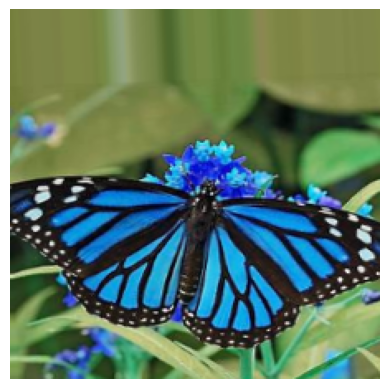

In [11]:
check_image_in_train(augmented_X, augmented_y, 4)

In [12]:
print('Train before Augmentation:',X_train_shape_before_aug)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train before Augmentation: (8775, 224, 224, 3)
Train shape: (11335, 224, 224, 3)
Test shape: (2925, 224, 224, 3)


In [13]:
del augmented_X
del augmented_y
del augmented_data_iterator

In [14]:
X_train_scaled = preprocess_input(np.copy(X_train))
X_test_scaled = preprocess_input(np.copy(X_test))

# Last layer neuron number
unique_class_number = len(np.unique(y_train))

This is a(n) cow


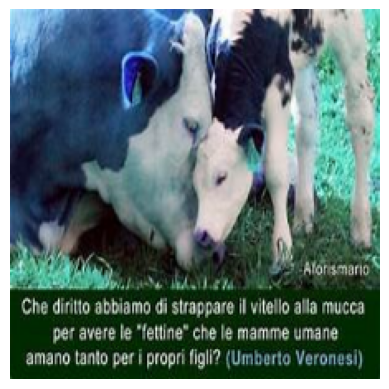

In [15]:
check_image_in_train(X_train, y_train, 100)

In [16]:
size_in_bytes = X_train_scaled.nbytes + X_test_scaled.nbytes
size_in_mb = size_in_bytes / (1024 * 1024)

print(f"Array size: {size_in_mb:.2f} MB")

Array size: 4094.18 MB


## Transfer Learning

In [17]:
# This was the starting Point, after hyperparamater optimization it was not used anymore
def train_base_model():
  # base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_scaled[0].shape)
  base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=X_train_scaled[0].shape)
  base_model.trainable = False ## Not trainable weights

  flatten_layer = layers.Flatten()
  dense_layer_1 = layers.Dense(100, activation='relu')
  dense_layer_2 = layers.Dense(100, activation='relu')
  prediction_layer = layers.Dense(unique_class_number, activation='softmax')


  model = models.Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      dense_layer_2,
      prediction_layer
  ])


  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

  class TimingCallback(tf.keras.callbacks.Callback):
      def on_epoch_begin(self, epoch, logs=None):
          self.epoch_start_time = time.time()

      def on_epoch_end(self, epoch, logs=None):
          epoch_end_time = time.time()
          epoch_time = epoch_end_time - self.epoch_start_time

          # Calculate remaining time based on the number of remaining epochs
          remaining_epochs = self.params['epochs'] - epoch - 1
          remaining_time = remaining_epochs * epoch_time

          print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds.")
          print(f"Estimated time remaining: {remaining_time:.2f} seconds")

  # Create the TimingCallback
  timing_callback = TimingCallback()

  # Use it in model.fit
  history = model.fit(X_train_scaled, y_train, epochs=3, batch_size=64,
                      validation_data=(X_test_scaled, y_test), callbacks=[timing_callback, es], verbose=2)

In [18]:
# This function creates the best model architecture, then load the weights
def get_best_model():
  # Load the hyperparameters and architecture details from the JSON file
  with open(os.getcwd() + '/drive/MyDrive/GridResults/BestModel/trial.json', 'r') as json_file:
      trial_data = json.load(json_file)

  # Extract hyperparameters
  hyperparameters = trial_data['hyperparameters']['values']
  num_dense_layers = hyperparameters['num_dense_layers']
  units = [hyperparameters[f'units_{i}'] for i in range(num_dense_layers)]
  l2_regularizer = [hyperparameters[f'l2_{i}'] for i in range(num_dense_layers)]
  learning_rate = hyperparameters['learning_rate']

  # Define the input shape based on your data
  input_shape = X_train_scaled[0].shape

  # Build the model based on hyperparameters
  model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
  model.trainable = False

  flatten_layer = layers.Flatten()

  dense_layers = []

  for i in range(num_dense_layers):
      dense_layers.append(layers.Dense(units[i], activation='relu', kernel_regularizer=keras.regularizers.l2(l2_regularizer[i])))

  prediction_layer = layers.Dense(unique_class_number, activation='softmax')

  model = keras.models.Sequential([
      model,
      flatten_layer,
      *dense_layers,
      prediction_layer
  ])

  # Compile the model
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  print(os.getcwd() + config.BEST_MODEL_FOLDER + 'checkpoint')

  model.load_weights(os.getcwd() + config.BEST_MODEL_FOLDER + 'checkpoint')

  return model

# model = get_best_model()
# model.save(os.getcwd() + config.BEST_MODEL_FOLDER + 'best_model.keras')


loaded_model = tf.keras.models.load_model(os.getcwd() + config.BEST_MODEL_FOLDER + 'best_model.keras')

In [19]:
y_pred = loaded_model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis = 1)

accuracy = accuracy_score(y_test, y_pred_labels)

print(f'Accuracy: {accuracy}')

92/92 [==============================] - 20s 100ms/step
Accuracy: 0.96


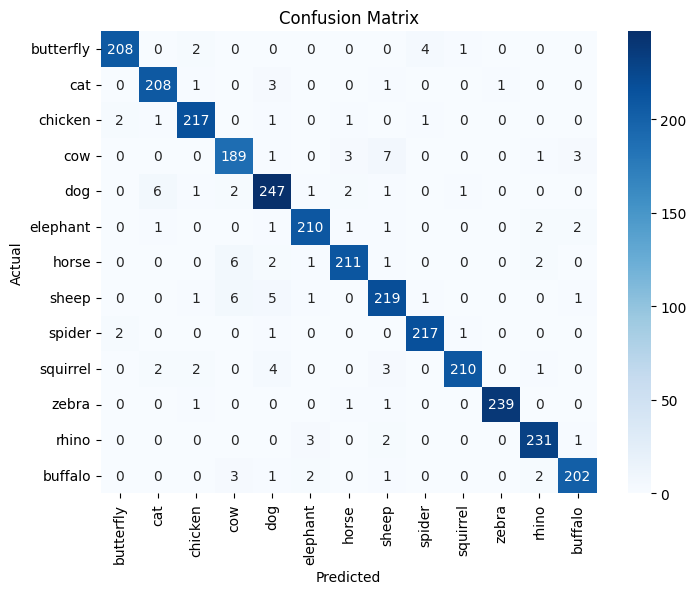

In [20]:
def plot_confusion_matrix(y_test, y_pred_labels):
  # Create the confusion matrix
  confusion = confusion_matrix(y_test, y_pred_labels)

  # Create a heatmap for visualization
  plt.figure(figsize=(8, 6))

  # Map numerical labels to their names using the label dictionary
  labels = [config.REVERSE_ANIMAL_DICT[label] for label in np.unique(y_test)]

  sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Display the heatmap
  plt.show()

plot_confusion_matrix(y_test, y_pred_labels)

In [21]:
import pandas as pd
result = pd.DataFrame({'Real': y_test, 'Predicted': y_pred_labels})
result['Real'] = result['Real'].map(config.REVERSE_ANIMAL_DICT)
result['Predicted'] = result['Predicted'].map(config.REVERSE_ANIMAL_DICT)

In [22]:
real_animal = 'sheep'
pred_animal = 'dog'

misclassified_images = result[(result['Real'] == real_animal) & (result['Predicted'] == pred_animal)]

Looks like the model can find even misclassified images by human!

[801, 1718, 1767, 2139, 2265]


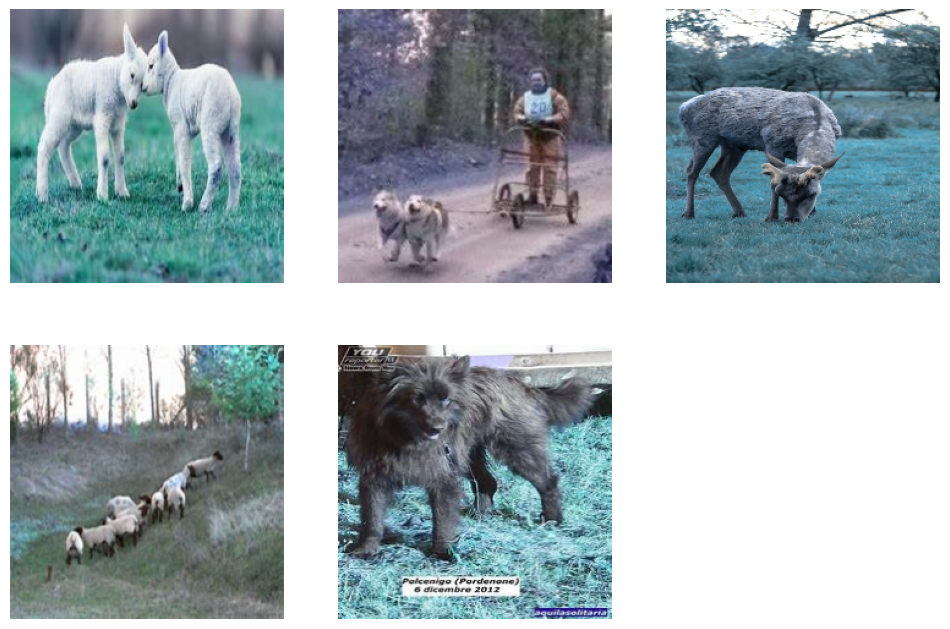

In [23]:
from PIL import Image
import numpy as np


def show_top_images(images, n=3):
    num_images = len(images)

    if num_images == 0:
        print("No images to display.")
        return

    rows = (num_images - 1) // n + 1

    fig, axes = plt.subplots(rows, n, figsize=(12, 4 * rows))
    axes = axes.flatten()  # Flatten the 2D axes array

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    for i in range(num_images, rows * n):
        fig.delaxes(axes[i])

    plt.show()

# Example usage:
max_images = 12
misclassified_indices = misclassified_images.index[:max_images].to_list()
print(misclassified_indices)
misclassified_images = [Image.fromarray(X_test[idx].astype('uint8')) for idx in misclassified_indices]
show_top_images(misclassified_images, n=3)

This is a(n) sheep


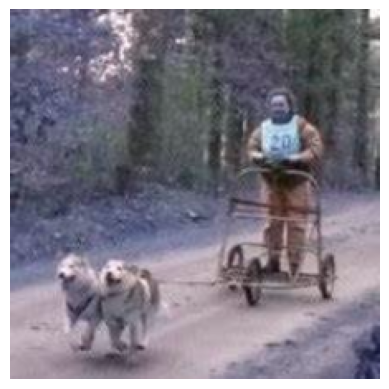

In [24]:
check_image_in_train(X_test, y_test, misclassified_indices[1]) # It seems like a misclassified image by human

## Evaulate Model

In [25]:
X_val_scaled = preprocess_input(np.copy(X_val))

In [26]:
y_val_pred = loaded_model.predict(X_val_scaled)
y_val_pred_labels = np.argmax(y_val_pred, axis = 1)

41/41 [==============================] - 5s 131ms/step


In [27]:
val_accuracy = accuracy_score(y_val, y_val_pred_labels) * 100

print(f'Accuracy: {val_accuracy}%')

Accuracy: 96.3076923076923%


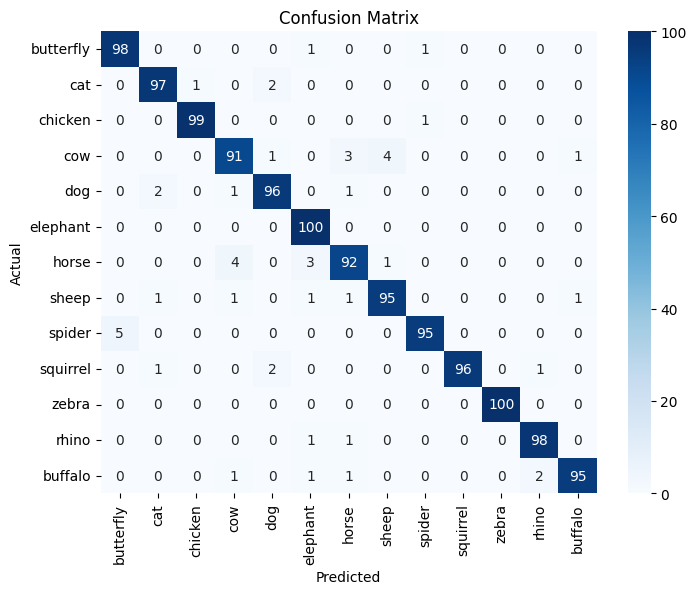

In [28]:
plot_confusion_matrix(y_val, y_val_pred_labels)

In [29]:
import pandas as pd
result = pd.DataFrame({'Real': y_val, 'Predicted': y_val_pred_labels})
result['Real'] = result['Real'].map(config.REVERSE_ANIMAL_DICT)
result['Predicted'] = result['Predicted'].map(config.REVERSE_ANIMAL_DICT)

In [30]:
real_animal = 'cat'
pred_animal = 'dog'

misclassified_images = result[(result['Real'] == real_animal) & (result['Predicted'] == pred_animal)]

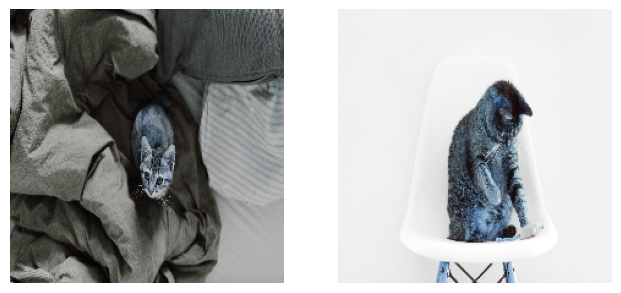

In [31]:
from PIL import Image
import numpy as np


def show_top_images(images, n=3):
    num_images = len(images)

    if num_images == 0:
        print("No images to display.")
        return

    rows = (num_images - 1) // n + 1

    fig, axes = plt.subplots(rows, n, figsize=(12, 4 * rows))
    axes = axes.flatten()  # Flatten the 2D axes array

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    for i in range(num_images, rows * n):
        fig.delaxes(axes[i])

    plt.show()

# Example usage:
max_images = 12
misclassified_indices = misclassified_images.index[:max_images].to_list()
misclassified_images = [Image.fromarray(X_val[idx].astype('uint8')) for idx in misclassified_indices]
show_top_images(misclassified_images, n=3)

## Hyperparameter Search Including Architecture

In [32]:
def hyperparameter_search():
  !pip install keras_tuner

  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  from keras_tuner.tuners import Hyperband
  from hyperopt import fmin, tpe, hp, Trials
  import os

  # Define a function to build the model
  def build_model(hp):
      # Define a hyperparameter for the number of dense layers
      num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=4, step=1)

      base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=X_train_scaled[0].shape)
      base_model.trainable = False

      flatten_layer = layers.Flatten()

      # Create a list to store the dense layers
      dense_layers = []

      # Add dense layers based on the value of num_dense_layers
      for i in range(num_dense_layers):
          # Define a hyperparameter for the number of units in each dense layer
          units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=128)
          l2_regularizer = hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-3, sampling='log')
          dense_layers.append(layers.Dense(units, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_regularizer)))

      # Define a hyperparameter for the learning rate
      learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

      prediction_layer = layers.Dense(unique_class_number, activation='softmax')

      model = keras.models.Sequential([
          base_model,
          flatten_layer,
          *dense_layers,
          prediction_layer
      ])

      model.compile(
          optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      return model

  # Choose a Tuner
  tuner = Hyperband(
      build_model,
      objective='val_accuracy',
      max_epochs=30,  # Maximum number of training epochs per configuration
      factor=3,  # Reduction factor for the number of configurations
      directory=os.getcwd() + '/drive/MyDrive/GridResults/'  # Directory to save results
  )

  # Define an Early Stopping callback (Optional)
  es = keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=6,
      restore_best_weights=True,
  )

  # Perform Hyperparameter Search
  tuner.search(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_test_scaled, y_test), callbacks=[es])

  # Get the Best Hyperparameters and Model
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  best_model = tuner.hypermodel.build(best_hps)

In [34]:
# loaded_model.save("animal_classifier_model")
# !zip -r /content/animal_classifier_model.zip /content/animal_classifier_model

  adding: content/animal_classifier_model/ (stored 0%)
  adding: content/animal_classifier_model/variables/ (stored 0%)
  adding: content/animal_classifier_model/variables/variables.index (deflated 78%)
  adding: content/animal_classifier_model/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: content/animal_classifier_model/saved_model.pb (deflated 92%)
  adding: content/animal_classifier_model/fingerprint.pb (stored 0%)
  adding: content/animal_classifier_model/keras_metadata.pb (deflated 96%)
  adding: content/animal_classifier_model/assets/ (stored 0%)
